In [1]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM, Net    
from misc import imutils
import matplotlib.pyplot as plt

In [19]:
val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
cam_weight_path = '/Users/Andy/Projects/dataset/Models/Classification/resnet50_fd.pth'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
data_loader = DataLoader(val_dataset, shuffle=False)

model = CAM()
model.eval()
model.load_state_dict(torch.load(cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [20]:
data_iter = iter(data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']

    strided_size = imutils.get_strided_size(size, 4)

    outputs = []
    for img in pack['img']:
        c, _ = model(img[0])
        outputs += [c]
    #outputs = [model(img[0]) for img in pack['img']]

    strided_cam = torch.sum(torch.stack(
        [F.interpolate(torch.unsqueeze(o, 0), strided_size, mode='bilinear', align_corners=False)[0] for o
         in outputs]), 0)

    valid_cat = torch.nonzero(label)[:, 0]

    strided_cam = strided_cam[valid_cat]
    strided_cam /= F.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5
    print(valid_cat)



tensor([ 1, 14])


In [21]:
print(strided_cam.min())
print(strided_cam.max())

tensor(9.6355e-05)
tensor(1.)


2007_000129


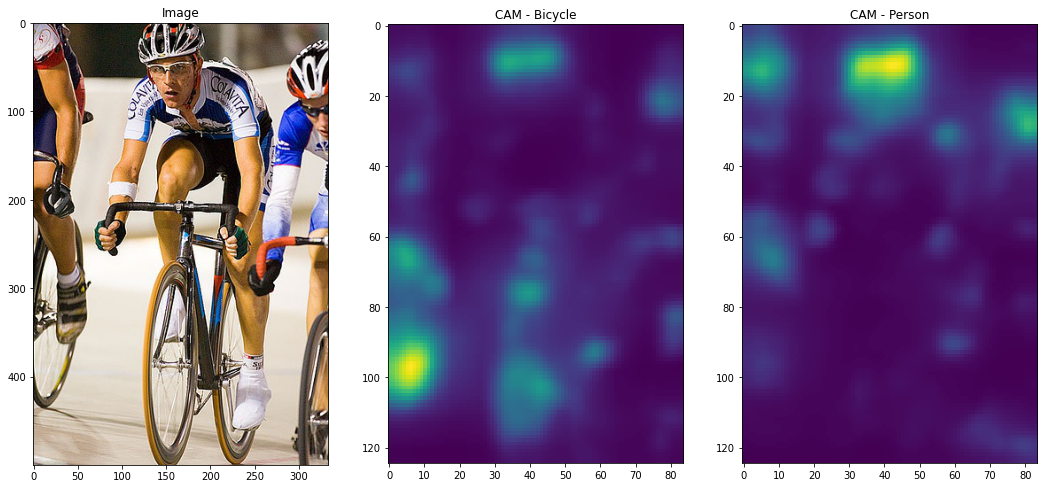

In [23]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(131)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(132)
plt.title('CAM - Bicycle')
ax2.imshow(strided_cam[0].squeeze())
ax3 = fig.add_subplot(133)
plt.title('CAM - Person')
ax3.imshow(strided_cam[1].squeeze())

In [66]:
img_name = voc12.dataloader.decode_int_filename(pack['name'][0])
orig_img_size = np.asarray(pack['size'])

edge, dp = model(pack['img'][0][0])

cams = strided_cam
keys = np.pad(valid_cat.numpy() + 1, (1, 0), mode='constant')

cam_downsized_values = cams

rw = indexing.propagate_to_edge(cam_downsized_values, edge, beta=10, exp_times=8, radius=5)

rw_up = F.interpolate(rw, scale_factor=4, mode='bilinear', align_corners=False)[..., 0, :orig_img_size[0], :orig_img_size[1]]
rw_up = rw_up / torch.max(rw_up)

rw_up_bg = F.pad(rw_up, (0, 0, 0, 0, 1, 0), value=0.25)
rw_pred = torch.argmax(rw_up_bg, dim=0).cpu().numpy()

rw_pred = keys[rw_pred]

ValueError: too many values to unpack (expected 2)

# Front-Door Criterion

Consider the following Structural Causal Model (SCM), this graph depicted the causal relationship between the image $X$ and its segmentation mask $Y$. The tag $Z$ is the image-level label assigned to each image. For instance, it would be "bicycle" and "person" for the image in the above. 

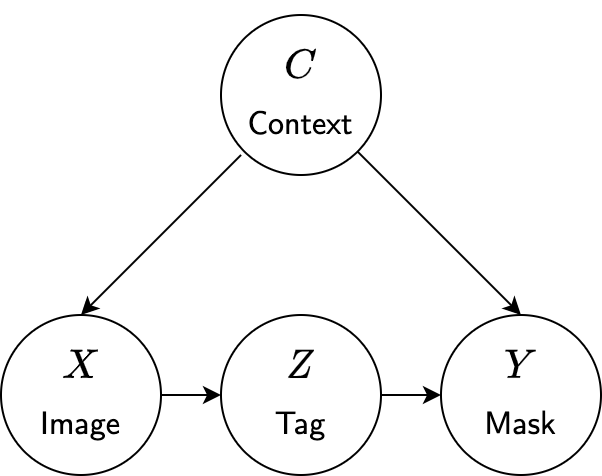

$C\rightarrow X$ and $C\rightarrow Y$. The context prior $C$ pictures the relationships among objects (e.g. person on the bicycle) and the characteristics (e.g., colour and shape) of objects in a scene. Hence, it determines what to picture in an image $X$. Moreover, it also causally influence the final segmentation mask $Y$. 

$X\rightarrow Z$. The tag $Z$ of an image is determined by the image $X$. Context prior $C$ cannot directly affect the labels $Z$ of an image. 

$Z\rightarrow Y$. The segmentation mask $Y$ is determined by the tag $Z$ as the tag(s) restricts the object to be segmented. For instance, if the background of an image contains semantic objects, if the tag doesn't include that class of the object, the segmentation mask $Y$ will assign "background" to those pixels.

Thanks to the graph, we can clearly see $C$ confounds $X$ and $Y$ via the backdoor path from $X$ to $Y$. However, $C$ is unobservable and hence cannot be used to block the backdoor path from $X$ to $Y$. Nevertheless, by applying two consecutive applications of the backdoor criterion, we can identify the causal effect $P(Y = y|do(X=x))$. This is also known as the **Front-Door Adjustment**. 

As the image tag $Z$ satisfies the front-door criterion relative to $(X, Y)$, then the causal effect of $X$ on $Y$ is identifiable is given by the formula

$$
P(y|do(x)) = \sum_zP(z|x)\sum_{x'}P(y|x',z)P(x')
$$

The derivation is as follows. We first note the causal effect of $X$ on $Z$ is identifiable, as there is no backdoor path from $X$ to $Z$. Thus, by **Back-Door Adjustment**, we have

$$
P(Z=z|do(X=x)) = P(Z=z|X=x)
$$

Second, we note the effect of $Z$ of $Y$ is also identifiable, since the backdoor path from $Z$ to $Y$, $Z\leftarrow X \leftarrow C \rightarrow Y$, can be blocked by conditioning on $X$. Thus, by **Back-Door Adjustment**, we have

$$
P(Y=y|do(Z=z)) = \sum_x P(Y=y|Z=z,X=x)
$$

Combining the above two equations gives us the results produced by **Front-Door Adjustment**. 

# Front-Door Adjustment for Weakly-Supervised Semantic Segmentation

- $P(z|x)$: A classification network trained on the dataset will produce a probability distribution $P(z|x)$ over the given classes in a dataset. For instance, in PASCAL VOC, it will be $B\times 20$. 
- $P(y|x, z)$: With the class activation map, we also can estimate $P(y|x, z)$ which contains the attention map over the given classes in a dataset. For instance, in PASCAL VOC, it will be $B\times 20 \times H \times W$.
- $P(x)$: Under the assumption $P(x)$ is uniform, i.e., $\frac{1}{N}$ where $N$ is the number of images in a given dataset. This assumption is reasonable as the training samples are equiprobable. 

However, the tricky part of utilizing front-door adjustment is the summations over all $x$ in the dataset, i.e., $\sum_{x'}P(y|x',z)P(x')$.  

## Solution 1: Batch

To avoid computing $P(y|x,z)$ for all the image $X$ in the dataset, we just take advantage of the data in each batch. 

## Solution 2: Memory Bank
To avoid computing $P(y|x,z)$ for all the image $X$ in the dataset, we can create a memory bank $M$ that contains a subset of training data. This is similar to the memory buffer in the reinforcement learning setting. The image in the memory bank can be updated in every iteration. It is reasonable to include images with a uniform class distribution. 


# Optimization

## Solution 1: Multiple Instance Learning

$P(y|do(x))$ produces one score $s_{i,j}^k = Y^k_{i,j}$ for each pixel location $(i,j)$ for class $k$. However, the pixel-level annotation is unobservabale and we only have image-level tag for each image. Thus, an aggreation function is required. To aggregate the pixel-level scores into a single image-level scores. The $aggreg$ function can be the convex approximation of the max function `Log-Sum-Exp`

$$
s^k = \frac{1}{r}\log\Big[\frac{1}{h^ow^o}\sum_{i,j}\exp(rs_{i,j}^k)\Big]
$$

where $r$ controls how smooth the approximation to be, and $h^ow^o$ is the height and width of the predicted class activation map. 

Further, we interpret $s^k$ as the image-level class scores and by applying a softmax 

$$
p(y|do(x)) = \frac{e^{s^k}}{\sum_{c\in \mathcal{C}}e^{s^c}}
$$

Finally, we maximize the log-likelihood with respect to the classification network $\theta$. 

$$
\mathcal{L}(\theta) = \sum_{(x,k)}\Big[s^k - \log\sum_{c\in \mathcal{C}}e^{s^c}\Big]
$$

In [2]:
val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
cam_weight_path = '/Users/Andy/Projects/dataset/Models/Classification/resnet50.pth'
size_h = 256
size_w = 256

val_dataset1 = voc12.dataloader.VOC12ClassificationDatasetFD(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0,),
                                                          size_h=size_h, size_w=size_w)

data_loader1 = DataLoader(val_dataset1, batch_size=2, shuffle=False)

model = CAM()
cls_model = Net()
model.eval()
model.load_state_dict(torch.load(cam_weight_path, map_location='cpu'))
cls_model.load_state_dict(torch.load(cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [3]:
data_iter = iter(data_loader1)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)



with torch.no_grad():
    img_names = pack['name']
    imgs = pack['img']
    print(imgs[:, 0].shape)
    labels = pack['label']
    size = pack['size']
    batch_size = 2
    strided_size = imutils.get_strided_size((size_h, size_w), 4)
    cams = []
    for b in range(batch_size):
        outputs = model(imgs[b])
        print(F.softmax(cls_model(imgs[b][0].unsqueeze(0)), dim=1).shape)
        strided_cam = F.interpolate(torch.unsqueeze(
            outputs, 0), strided_size, mode='bilinear', align_corners=False)[0]
        #strided_cam = strided_cam / (F.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5)
        cams += [strided_cam.unsqueeze(0)]
    cams = torch.cat(cams, dim=0)

torch.Size([2, 3, 256, 256])
torch.Size([1, 20])
torch.Size([1, 20])


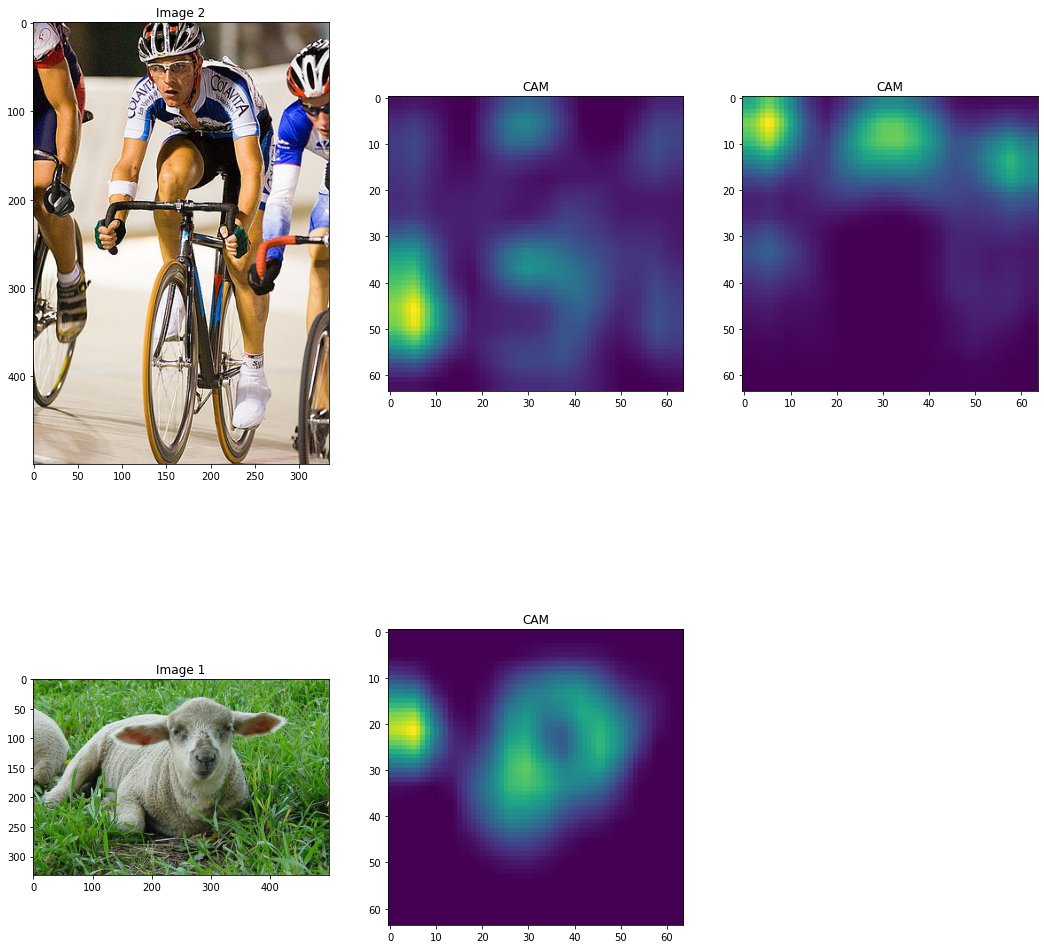

In [26]:
im1 = Image.open(os.path.join(voc12_root, 'JPEGImages', img_names[0] + '.jpg'))
im2 = Image.open(os.path.join(voc12_root, 'JPEGImages', img_names[1] + '.jpg'))

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(231)
plt.title('Image 2')
ax1.imshow(im1)
ax2 = fig.add_subplot(232)
plt.title('CAM')
ax2.imshow(cams[0][1].squeeze())
ax3 = fig.add_subplot(233)
plt.title('CAM')
ax3.imshow(cams[0][14].squeeze())

ax4 = fig.add_subplot(234)
plt.title('Image 1')
ax4.imshow(im2)
ax4 = fig.add_subplot(235)
plt.title('CAM')
ax4.imshow(cams[1][16].squeeze())

In [28]:
def lse_agg(cam, r):
    return (1/r) * torch.logsumexp(cam * r, dim=(2, 3))

bce_loss = torch.nn.BCEWithLogitsLoss()

all_cams = torch.tensor(np.load('./scam.npy'))
cls_p = cls_model(imgs[:, 0])

wcams = cls_p.unsqueeze(2).unsqueeze(2) * all_cams
x = lse_agg(wcams, r=1)
x = x / torch.sum(x, dim=1).unsqueeze(1)

print(labels.shape)

loss = bce_loss(x, labels)
loss1 = F.multilabel_soft_margin_loss(x, labels)
print(loss, loss1)

torch.Size([2, 20])
tensor(0.7137, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.7137, grad_fn=<MeanBackward0>)


torch.Size([2, 20])


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [32]:
def lse_agg(cam, r):
    return (1/r) * torch.mean(cam * r, dim=(2,3))

def norm(p):
    return p/p.sum()

acams = cams
# print(acams.shape)
# print(acams[1][17].sum())
# print(acams[1][16].sum())

# x = acams[1][17].unsqueeze(0).unsqueeze(0)
# print(x.min())
# print(lse_agg(x, r=1))
# # P(z|x) - might detach
# p = lse_agg(acams, r=1)
# p = p/torch.sum(p,dim=1).unsqueeze(1)
# print(p)

# print(p.shape)
# print(p[1][17])
# print(p[1][16])
#P(y|do(x))
scams = torch.mean(acams, dim=0)
C = acams.shape[1]
wcams = torch.zeros_like(acams)
print(p.shape)
for c in range(C):
    scam = torch.zeros_like(scams)
    scam[c] = scams[c]
    wcams += p[:, c].unsqueeze(1).unsqueeze(1).unsqueeze(1) * scam
x = lse_agg(wcams, r=1)
#x = x/torch.sum(x,dim=1).unsqueeze(1)
print(x)

print(x[0][1])
print(x[0][12])
print(x[0][14])
print(x[1][16])
print(x[1][17])
print(x)
print(torch.argmax(x, dim=1))


torch.Size([2, 20])
tensor([[2.1646e-02, 9.3311e+00, 0.0000e+00, 0.0000e+00, 2.6261e-02, 4.0928e-03,
         8.6205e-03, 0.0000e+00, 6.9565e-03, 0.0000e+00, 5.0216e-04, 0.0000e+00,
         4.1445e-01, 1.7323e-01, 9.9489e+00, 3.0832e-03, 0.0000e+00, 9.9883e-06,
         7.3576e-06, 1.6795e-01],
        [0.0000e+00, 0.0000e+00, 1.3845e-04, 0.0000e+00, 1.8094e-02, 0.0000e+00,
         6.6128e-03, 3.3347e-01, 0.0000e+00, 1.1548e-01, 0.0000e+00, 8.2668e-01,
         1.8867e-01, 6.6729e-02, 0.0000e+00, 0.0000e+00, 1.0284e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
tensor(9.3311)
tensor(0.4145)
tensor(9.9489)
tensor(10.2844)
tensor(0.)
tensor([[2.1646e-02, 9.3311e+00, 0.0000e+00, 0.0000e+00, 2.6261e-02, 4.0928e-03,
         8.6205e-03, 0.0000e+00, 6.9565e-03, 0.0000e+00, 5.0216e-04, 0.0000e+00,
         4.1445e-01, 1.7323e-01, 9.9489e+00, 3.0832e-03, 0.0000e+00, 9.9883e-06,
         7.3576e-06, 1.6795e-01],
        [0.0000e+00, 0.0000e+00, 1.3845e-04, 0.0000e+00, 1.8094e-02, 0.0000e